# Exploring CART versus Linear Regression

# Overview & Context

- **Context-Dependent Model Evaluation:**
  - **Comparing Models:**  
    - The "best" model depends on the underlying data and the problem at hand.
    - Your analysis should help you see where each model excels and where it may fall short.
  - **Learning Opportunity:**  
    - Use this assignment to understand trade-offs such as interpretability vs. flexibility and bias vs. variance.

- **When to Prefer Linear Regression:**
  - **Applicability:**
    - When the relationship between the predictors and the target is approximately linear.
  - **Interpretability:**
    - The model is highly interpretable—each coefficient provides insight into how a predictor influences the target.
  - **Assumptions:**
    - Ideal if assumptions like linearity, normality of residuals, homoscedasticity, and independence of errors are reasonably met.

- **When to Prefer Regression Trees (CART):**
  - **Flexibility:**
    - Better suited for capturing complex and non-linear relationships that a linear model may miss.
  - **Model Structure:**
    - Provides a set of if-then rules that can segment the data into different regimes.
  - **Overfitting Risk:**
    - Can be more prone to overfitting if not properly tuned (using parameters such as `max_depth` and `min_samples_split`).
  - **Use-case:**
    - Ideal when the data exhibits non-linear patterns or when you want to automatically capture interactions between features.



## Predicting Airline Ticket Prices

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats

# Scikit-learn for modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Set global plotting style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

## EDA

In [42]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Load and Explore the Dataset

project_folder = '/content/drive/My Drive/Colab Notebooks/'

file_path = os.path.join(project_folder, "processed_data.csv")

# Read the CSV
df = pd.read_csv(file_path)


In [ ]:
# Define the number of bins (for quantiles) and the maximum samples per bin
num_bins = 5
n_samples_per_bin = 200

# Create a temporary binned column using pd.qcut.
# This column is only used for sampling and will be dropped later.
df['temp_fare_bin'] = pd.qcut(df['totalFare'], q=num_bins, duplicates='drop')

# For each bin, sample up to n_samples_per_bin rows (or all rows if fewer exist)
balanced_subset = (
    df.groupby('temp_fare_bin', group_keys=False)
      .apply(lambda x: x.sample(n=min(len(x), n_samples_per_bin), random_state=42))
      .reset_index(drop=True)
)

print("Balanced subset shape:", balanced_subset.shape)

# Drop the temporary binned column so that the column structure remains unchanged.
balanced_subset = balanced_subset.drop(columns=['temp_fare_bin'])

# Overwrite the original df with this balanced subset for the remainder of the analysis.
df = balanced_subset.copy()

# Display column names to verify structure
print("Columns in dataset:")
print(df.columns)

# Preview the first few rows and columns
df.head(10)

<ipython-input-24-4ab6c390204f>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('temp_fare_bin', group_keys=False)


Balanced subset shape: (1000, 28)
Columns in dataset:
Index(['legId', 'searchDate', 'flightDate', 'startingAirport',
       'destinationAirport', 'fareBasisCode', 'travelDuration', 'elapsedDays',
       'isBasicEconomy', 'isRefundable', 'isNonStop', 'baseFare', 'totalFare',
       'seatsRemaining', 'totalTravelDistance',
       'segmentsDepartureTimeEpochSeconds', 'segmentsDepartureTimeRaw',
       'segmentsArrivalTimeEpochSeconds', 'segmentsArrivalTimeRaw',
       'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode',
       'segmentsAirlineName', 'segmentsAirlineCode',
       'segmentsEquipmentDescription', 'segmentsDurationInSeconds',
       'segmentsDistance', 'segmentsCabinCode'],
      dtype='object')


<ipython-input-24-4ab6c390204f>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), n_samples_per_bin), random_state=42))


,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,f242ccd23dca24fe4b96107eab527525,2022-08-06,2022-09-13,DFW,DEN,TA7NA0BG,PT7H56M,0,True,False,...,1663084380||1663103100,2022-09-13T09:53:00.000-06:00||2022-09-13T15:0...,SLC||DEN,DFW||SLC,Delta||Delta,DL||DL,Airbus A320||Boeing 737-800,9840||5100,992||380,coach||coach
1,a04fa800f1b3bbd160e565ff7ef64604,2022-06-03,2022-07-04,MIA,DEN,RA7NR,PT4H35M,0,False,False,...,1656946800,2022-07-04T09:00:00.000-06:00,DEN,MIA,Spirit Airlines,NK,AIRBUS INDUSTRIE A321 SHARKLETS,16500,NaN,coach
2,46d909d3bb2b3285ca75ab07a76a3ba0,2022-07-25,2022-09-10,LGA,DFW,R3AHZRU3,PT3H50M,0,False,False,...,1662860100,2022-09-10T20:35:00.000-05:00,DFW,LGA,JetBlue Airways,B6,Boeing 737-800,13800,1380,coach
3,e1ba2e4e4bd0dce601e8ab4755289ce8,2022-09-30,2022-10-18,DFW,IAD,TAU4JKBS,PT5H20M,0,True,False,...,1666093080||1666108200,2022-10-18T06:38:00.000-05:00||2022-10-18T11:5...,IAH||IAD,DFW||IAH,United||United,UA||UA,Airbus A319||Boeing 737-800,4080||10920,233||1203,coach||coach
4,7864e96c7689c7a6b9d0a11f3f267d6d,2022-07-03,2022-07-06,DEN,LGA,TAA0PHEN,PT8H31M,1,False,False,...,1657185480||1657204200,2022-07-07T05:18:00.000-04:00||2022-07-07T10:3...,IAD||LGA,DEN||IAD,United||United,UA||UA,Boeing 737-900||,11940||5280,1473||221,coach||coach
5,32e6ca8f7bdcb13eae152cbd9901337d,2022-06-15,2022-08-12,DEN,LAX,SAA7AKEN,PT2H27M,0,False,False,...,1660341960,2022-08-12T15:06:00.000-07:00,LAX,DEN,United,UA,Boeing 737-900,8820,848,coach
6,5c37404fd3c832ab0502756971332dc0,2022-10-01,2022-11-05,DFW,CLT,VAUSA5BC,PT5H26M,0,True,False,...,1667667000||1667679000,2022-11-05T12:50:00.000-04:00||2022-11-05T16:1...,ATL||CLT,DFW||ATL,Delta||Delta,DL||DL,Airbus A321||Boeing 717,7560||4260,725||228,coach||coach
7,3a11c515c8649c3e26af1aab481452a0,2022-06-12,2022-08-03,BOS,MIA,G7AJZNN3,PT6H47M,0,False,False,...,1659530460||1659548820,2022-08-03T08:41:00.000-04:00||2022-08-03T13:4...,PHL||MIA,BOS||PHL,American Airlines||American Airlines,AA||AA,||Airbus A321,6060||10620,280||1016,coach||coach
8,3f37a42a265de463984d8ef79ab0fa9f,2022-10-02,2022-10-30,DEN,CLT,LAA7AWEN,PT5H51M,0,False,False,...,1667140080||1667152260,2022-10-30T09:28:00.000-05:00||2022-10-30T13:5...,ORD||CLT,DEN||ORD,United||United,UA||UA,Airbus A319||Embraer 175 (Enhanced Winglets),8880||7920,903||592,coach||coach
9,f5643ec4790828dc52cad964f91eaf26,2022-05-04,2022-06-16,CLT,JFK,XAVQA0BQ,PT2H9M,0,True,False,...,1655431440,2022-06-16T22:04:00.000-04:00,JFK,CLT,Delta,DL,Canadair Regional Jet 900,7740,545,coach


In [ ]:
# -- Drop unnecessary columns --
# We drop identifiers, date strings, and other columns that are not used for prediction.
cols_to_drop = [
    'legId', 'searchDate', 'flightDate', 'fareBasisCode',
    'segmentsDepartureTimeEpochSeconds', 'segmentsDepartureTimeRaw',
    'segmentsArrivalTimeEpochSeconds', 'segmentsArrivalTimeRaw',
    'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode',
    'segmentsAirlineName', 'segmentsAirlineCode',
    'segmentsEquipmentDescription', 'segmentsDurationInSeconds',
    'segmentsDistance', 'segmentsCabinCode',
    'baseFare'  # Dropped to avoid collinearity with totalFare
]
df = df.drop(columns=cols_to_drop, errors='ignore')

# -- Convert boolean columns to integers --
bool_cols = ['isBasicEconomy', 'isRefundable', 'isNonStop']
for col in bool_cols:
    if col in df.columns:
        df[col] = df[col].astype(int)

# -- Convert travelDuration (ISO 8601 format) to total minutes --
# Example format: "PT5H45M"
def convert_duration_iso(duration_str):
    """
    Convert a duration string in ISO 8601 format (e.g., "PT5H45M") to total minutes.
    If the format is not recognized or the value is missing, returns np.nan.
    """
    if pd.isna(duration_str):
        return np.nan
    try:
        # Remove the "PT" prefix if present
        if duration_str.startswith("PT"):
            duration_str = duration_str[2:]
        hours = 0
        minutes = 0
        if "H" in duration_str:
            parts = duration_str.split("H")
            hours = int(parts[0])
            # The remainder should contain minutes ending with "M"
            if len(parts) > 1 and "M" in parts[1]:
                minutes = int(parts[1].split("M")[0])
        elif "M" in duration_str:
            minutes = int(duration_str.split("M")[0])
        return hours * 60 + minutes
    except Exception as e:
        return np.nan

# Create a new column 'travelDurationMinutes'
if 'travelDuration' in df.columns:
    df['travelDurationMinutes'] = df['travelDuration'].apply(convert_duration_iso)
    print("\nTravel Duration conversion preview:")
    print(df[['travelDuration', 'travelDurationMinutes']].head())
else:
    print("Column 'travelDuration' not found.")

# -- For simplicity, we drop rows with missing values in our key features --
# We'll use the following features (interpretable predictors):
selected_features = ['travelDurationMinutes', 'totalTravelDistance', 'isBasicEconomy', 'isRefundable', 'isNonStop']

# Ensure numeric columns are converted properly (e.g., totalTravelDistance)
for col in ['totalTravelDistance']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Set target variable (using totalFare)
if 'totalFare' not in df.columns:
    raise ValueError("Target column 'totalFare' not found in the dataset.")

# Combine features and target; then drop rows with NaNs in these columns
df_model = df[selected_features + ['totalFare']].replace([np.inf, -np.inf], np.nan).dropna()

# Reassign X and y
X = df_model[selected_features]
y = df_model['totalFare']

print("\nCleaned Features Sample:")
print(X.head())
print("\nCleaned Target Sample:")
print(y.head())


Travel Duration conversion preview:
  travelDuration  travelDurationMinutes
0        PT7H56M                  476.0
1        PT4H35M                  275.0
2        PT3H50M                  230.0
3        PT5H20M                  320.0
4        PT8H31M                  511.0

Cleaned Features Sample:
   travelDurationMinutes  totalTravelDistance  isBasicEconomy  isRefundable  \
0                  476.0               1372.0               1             0   
2                  230.0               1380.0               0             0   
3                  320.0               1436.0               1             0   
4                  511.0               1694.0               0             0   
5                  147.0                848.0               0             0   

   isNonStop  
0          0  
2          1  
3          0  
4          0  
5          1  

Cleaned Target Sample:
0    127.6
2    148.6
3    172.6
4    167.6
5    158.6
Name: totalFare, dtype: float64



Summary statistics of features:
       travelDurationMinutes  totalTravelDistance  isBasicEconomy  \
count             924.000000           924.000000      924.000000   
mean              412.147186          1611.847403        0.155844   
std               218.126207           838.359340        0.362904   
min                73.000000           185.000000        0.000000   
25%               247.250000           924.000000        0.000000   
50%               394.500000          1429.000000        0.000000   
75%               535.500000          2403.000000        0.000000   
max              1228.000000          4049.000000        1.000000   

       isRefundable   isNonStop  
count    924.000000  924.000000  
mean       0.001082    0.290043  
std        0.032898    0.454028  
min        0.000000    0.000000  
25%        0.000000    0.000000  
50%        0.000000    0.000000  
75%        0.000000    1.000000  
max        1.000000    1.000000  


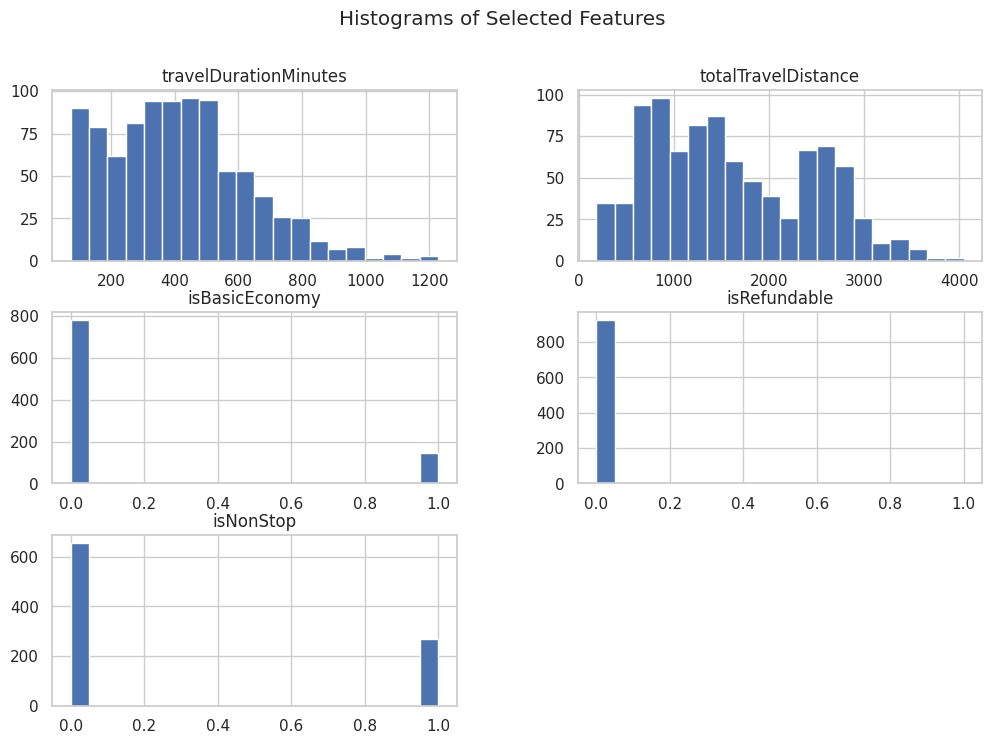

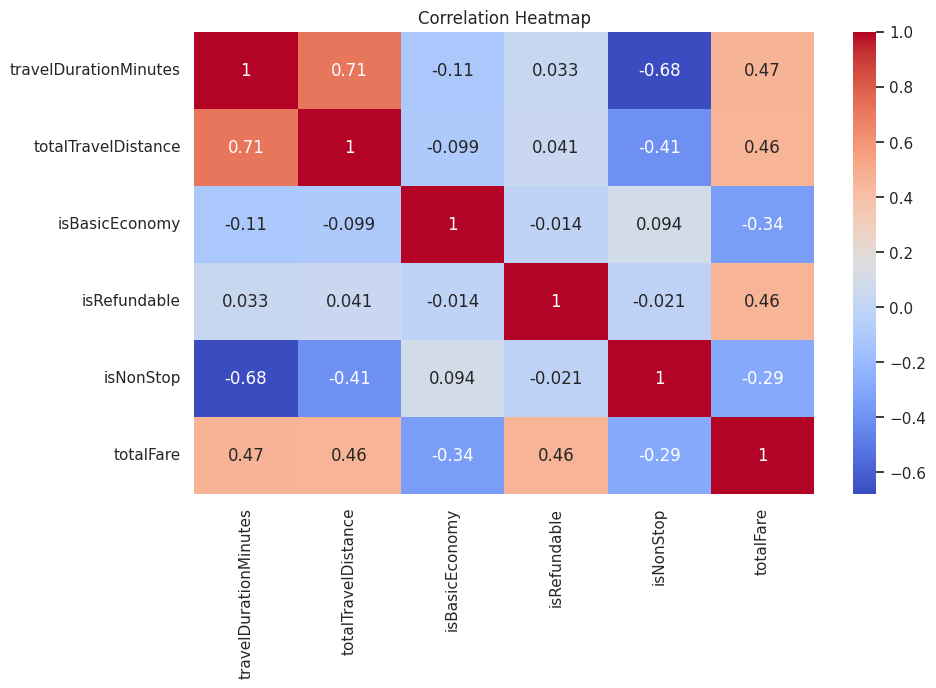

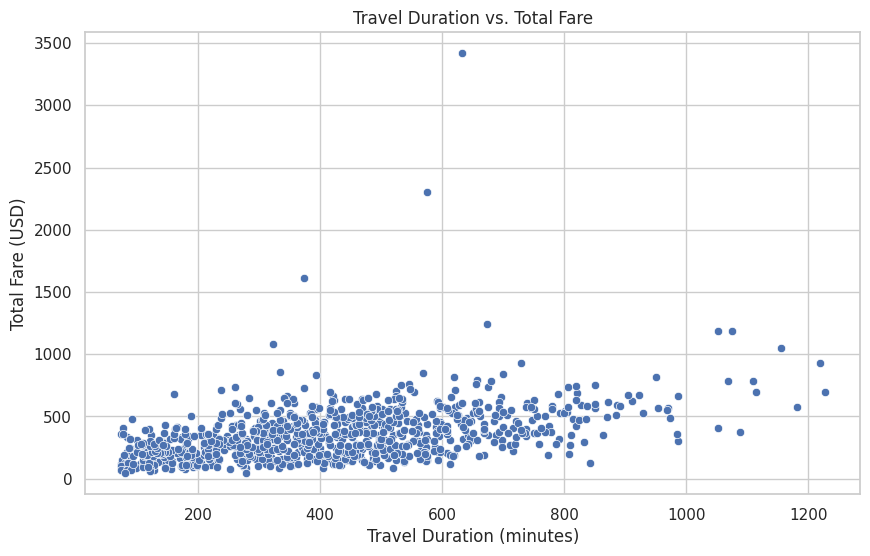

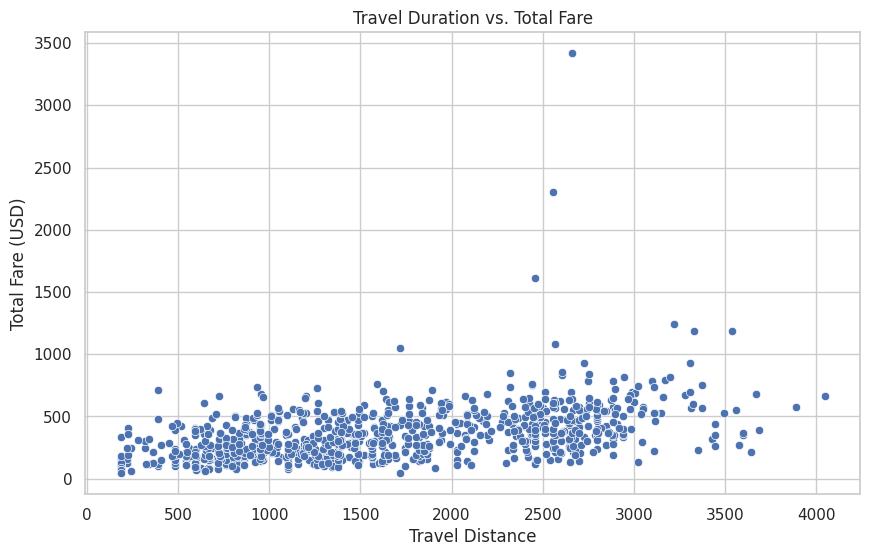

In [ ]:
# EDA

print("\nSummary statistics of features:")
print(X.describe())

# Histograms for each feature
X.hist(bins=20, figsize=(12,8))
plt.suptitle("Histograms of Selected Features")
plt.show()

# Correlation heatmap among features and target
corr_data = X.copy()
corr_data['totalFare'] = y
plt.figure()
sns.heatmap(corr_data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Scatter plot: travelDurationMinutes vs. totalFare
df_plot = pd.DataFrame({
    'travelDurationMinutes': X['travelDurationMinutes'],
    'totalFare': y
})
plt.figure()
sns.scatterplot(data=df_plot, x='travelDurationMinutes', y='totalFare')
plt.xlabel("Travel Duration (minutes)")
plt.ylabel("Total Fare (USD)")
plt.title("Travel Duration vs. Total Fare")
plt.show()

# Scatter plot: totalTravelDistance vs. totalFare
df_plot = pd.DataFrame({
    'totalTravelDistance': X['totalTravelDistance'],
    'totalFare': y
})
plt.figure()
sns.scatterplot(data=df_plot, x='totalTravelDistance', y='totalFare')
plt.xlabel("Travel Distance")
plt.ylabel("Total Fare (USD)")
plt.title("Travel Duration vs. Total Fare")
plt.show()

## Implement Linear Regression

- Use `sklearn.linear_model.LinearRegression` to train a model on the training set.

Evaluation Metrics:
- Root Mean Squared Error (RMSE)
- R-squared (R²)

Visualizations:
- Plot actual vs. predicted Ticket Prices.
- Residual analysis (residual histogram, residual vs. fitted plot).


Linear Regression Performance:
RMSE: 130.76285617289992
R-squared: 0.4093827751128838


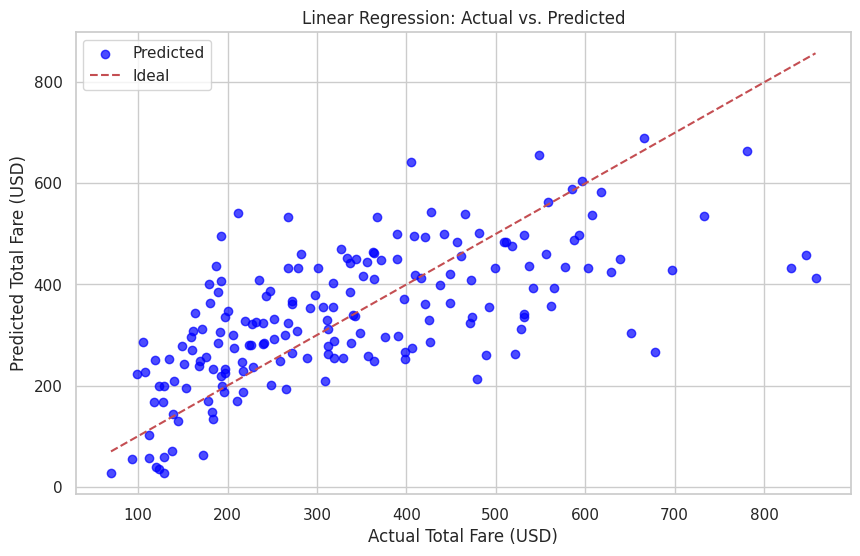

In [ ]:
# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on test set
y_pred_lr = lr.predict(X_test)

# Calculate evaluation metrics: RMSE and R-squared
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("\nLinear Regression Performance:")
print("RMSE:", rmse_lr)
print("R-squared:", r2_lr)

# Plot Actual vs. Predicted for Linear Regression
plt.figure()
plt.scatter(y_test, y_pred_lr, color='blue', alpha=0.7, label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.xlabel("Actual Total Fare (USD)")
plt.ylabel("Predicted Total Fare (USD)")
plt.title("Linear Regression: Actual vs. Predicted")
plt.legend()
plt.show()

## Implement Regression Tree

- Use `sklearn.tree.DecisionTreeRegressor` to train a regression tree model.
- Discuss hyperparameters such as `max_depth`, `min_samples_split`, and `min_impurity_decrease` briefly.

Model Evaluation:
- Evaluate using the same metrics (MSE, MAE, R²).

Visualizations:
- Plot actual vs. predicted values.
- Visualize the tree structure using plot_tree.


Regression Tree Performance:
RMSE: 133.46009102384028
R-squared: 0.3847662579343172


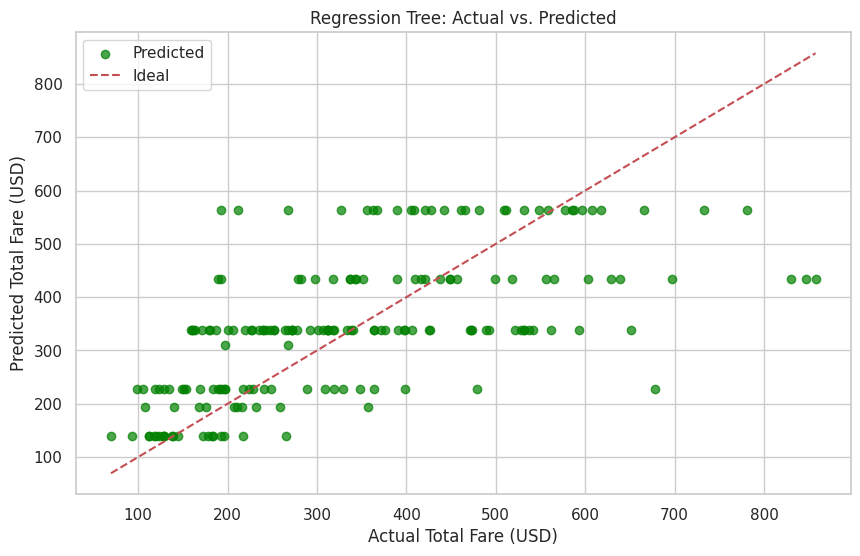

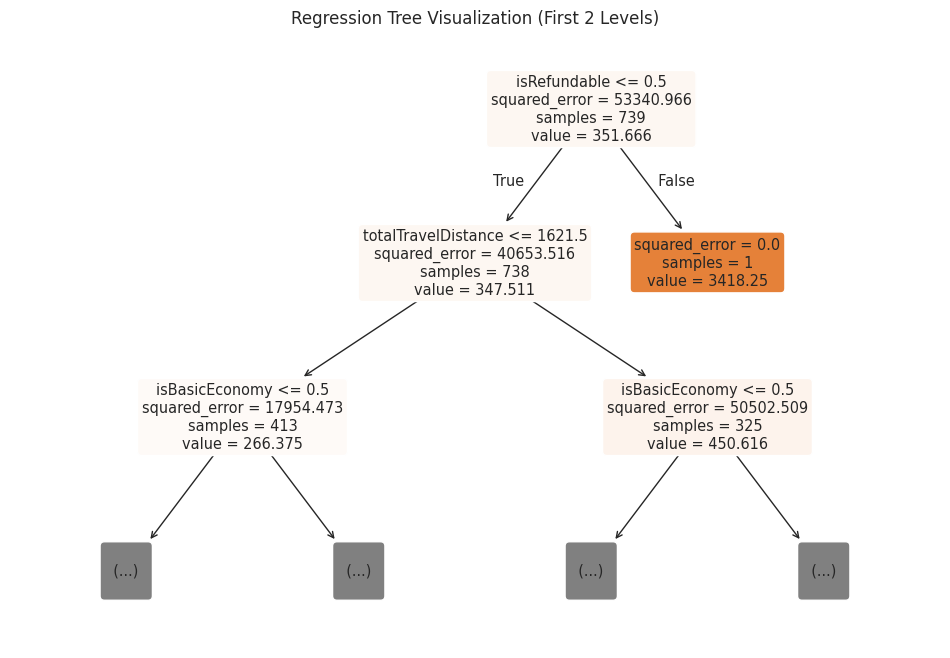

In [ ]:
# Initialize and train a Decision Tree Regressor
tree = DecisionTreeRegressor(max_depth=4, random_state=42)
tree.fit(X_train, y_train)

# Predict on test data using the regression tree
y_pred_tree = tree.predict(X_test)

# Calculate evaluation metrics for the tree model: RMSE and R-squared
rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_tree))
r2_tree = r2_score(y_test, y_pred_tree)

print("\nRegression Tree Performance:")
print("RMSE:", rmse_tree)
print("R-squared:", r2_tree)

# Plot Actual vs. Predicted for the Regression Tree
plt.figure()
plt.scatter(y_test, y_pred_tree, color='green', alpha=0.7, label='Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.xlabel("Actual Total Fare (USD)")
plt.ylabel("Predicted Total Fare (USD)")
plt.title("Regression Tree: Actual vs. Predicted")
plt.legend()
plt.show()

# Visualize the structure of the regression tree (limit to first 2 levels for clarity)
plt.figure(figsize=(12, 8))
plot_tree(tree, feature_names=X.columns, filled=True, rounded=True, max_depth=2)
plt.title("Regression Tree Visualization (First 2 Levels)")
plt.show()

## Compare Linear Regression and Regression Trees

Evaluation Metrics Comparison:
- Present a table comparing MSE, MAE, and R² for both models.

Residual Analysis:
- Compare residual distributions to understand how each model behaves.

Insights:
- Linear regression may struggle if the relationship is non-linear.
- Regression trees can model non-linearity but might be more “step-like” in predictions.

Visual Examples:
- Side-by-side scatter plots of actual vs. predicted values for each model.

In [ ]:
# Summarize evaluation metrics for both models
metrics_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Regression Tree'],
    'RMSE': [rmse_lr, rmse_tree],
    'R-squared': [r2_lr, r2_tree]
})
print("\nComparison of Models:")
print(metrics_df)




Comparison of Models:
               Model        RMSE  R-squared
0  Linear Regression  130.762856   0.409383
1    Regression Tree  133.460091   0.384766


## Next Steps: Improving Our Regression Tree

Our initial Regression Tree shows suboptimal performance.

### Complete These Potential Improvements As A Group:

Do all of the Hyperparameter Tuning.

1. **Hyperparameter Tuning:**
   - **`max_depth`, `min_samples_split`, `min_samples_leaf`:**  
     Deeper trees can overfit; restricting depth or requiring more samples per leaf can improve generalization.
   - **`min_impurity_decrease`:**  
     Require a minimum reduction in impurity for a split to be accepted, limiting growth on marginal improvements.
   - **Cross Validation:**  
     Use techniques like `GridSearchCV` or `RandomizedSearchCV` to systematically find the best combination of these parameters.


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9, 11],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'min_impurity_decrease': [0.0, 0.001, 0.01, 0.1]
}

# Initialize the Decision Tree Regressor
tree = DecisionTreeRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=tree, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found by GridSearchCV
print("Best hyperparameters:", grid_search.best_params_)

# Get the best model from the grid search
best_tree = grid_search.best_estimator_

# Predict on the test set using the best model
y_pred_best_tree = best_tree.predict(X_test)

# Evaluate the best model (using RMSE as an example)
rmse_best_tree = np.sqrt(mean_squared_error(y_test, y_pred_best_tree))
print("RMSE of best model:", rmse_best_tree)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best hyperparameters: {'max_depth': 5, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10}
RMSE of best model: 130.95451632809323


In [ ]:
project_folder = '/content/drive/My Drive/Colab Notebooks/'

file_path = os.path.join(project_folder, "processed_data.csv")

# Read the CSV
df = pd.read_csv(file_path)

In [44]:
# Define the number of bins (for quantiles) and the maximum samples per bin
num_bins = 5
n_samples_per_bin = 200

# Create a temporary binned column using pd.qcut.
# This column is only used for sampling and will be dropped later.
df['temp_fare_bin'] = pd.qcut(df['totalFare'], q=num_bins, duplicates='drop')

# For each bin, sample up to n_samples_per_bin rows (or all rows if fewer exist)
balanced_subset = (
    df.groupby('temp_fare_bin', group_keys=False)
      .apply(lambda x: x.sample(n=min(len(x), n_samples_per_bin), random_state=42))
      .reset_index(drop=True)
)

print("Balanced subset shape:", balanced_subset.shape)

# Drop the temporary binned column so that the column structure remains unchanged.
balanced_subset = balanced_subset.drop(columns=['temp_fare_bin'])

# Overwrite the original df with this balanced subset for the remainder of the analysis.
df = balanced_subset.copy()

# Display column names to verify structure
print("Columns in dataset:")
print(df.columns)

# Preview the first few rows and columns
df.head(10)

<ipython-input-44-4ab6c390204f>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('temp_fare_bin', group_keys=False)


Balanced subset shape: (1000, 28)
Columns in dataset:
Index(['legId', 'searchDate', 'flightDate', 'startingAirport',
       'destinationAirport', 'fareBasisCode', 'travelDuration', 'elapsedDays',
       'isBasicEconomy', 'isRefundable', 'isNonStop', 'baseFare', 'totalFare',
       'seatsRemaining', 'totalTravelDistance',
       'segmentsDepartureTimeEpochSeconds', 'segmentsDepartureTimeRaw',
       'segmentsArrivalTimeEpochSeconds', 'segmentsArrivalTimeRaw',
       'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode',
       'segmentsAirlineName', 'segmentsAirlineCode',
       'segmentsEquipmentDescription', 'segmentsDurationInSeconds',
       'segmentsDistance', 'segmentsCabinCode'],
      dtype='object')


<ipython-input-44-4ab6c390204f>:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(len(x), n_samples_per_bin), random_state=42))


,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,f242ccd23dca24fe4b96107eab527525,2022-08-06,2022-09-13,DFW,DEN,TA7NA0BG,PT7H56M,0,True,False,...,1663084380||1663103100,2022-09-13T09:53:00.000-06:00||2022-09-13T15:0...,SLC||DEN,DFW||SLC,Delta||Delta,DL||DL,Airbus A320||Boeing 737-800,9840||5100,992||380,coach||coach
1,a04fa800f1b3bbd160e565ff7ef64604,2022-06-03,2022-07-04,MIA,DEN,RA7NR,PT4H35M,0,False,False,...,1656946800,2022-07-04T09:00:00.000-06:00,DEN,MIA,Spirit Airlines,NK,AIRBUS INDUSTRIE A321 SHARKLETS,16500,NaN,coach
2,46d909d3bb2b3285ca75ab07a76a3ba0,2022-07-25,2022-09-10,LGA,DFW,R3AHZRU3,PT3H50M,0,False,False,...,1662860100,2022-09-10T20:35:00.000-05:00,DFW,LGA,JetBlue Airways,B6,Boeing 737-800,13800,1380,coach
3,e1ba2e4e4bd0dce601e8ab4755289ce8,2022-09-30,2022-10-18,DFW,IAD,TAU4JKBS,PT5H20M,0,True,False,...,1666093080||1666108200,2022-10-18T06:38:00.000-05:00||2022-10-18T11:5...,IAH||IAD,DFW||IAH,United||United,UA||UA,Airbus A319||Boeing 737-800,4080||10920,233||1203,coach||coach
4,7864e96c7689c7a6b9d0a11f3f267d6d,2022-07-03,2022-07-06,DEN,LGA,TAA0PHEN,PT8H31M,1,False,False,...,1657185480||1657204200,2022-07-07T05:18:00.000-04:00||2022-07-07T10:3...,IAD||LGA,DEN||IAD,United||United,UA||UA,Boeing 737-900||,11940||5280,1473||221,coach||coach
5,32e6ca8f7bdcb13eae152cbd9901337d,2022-06-15,2022-08-12,DEN,LAX,SAA7AKEN,PT2H27M,0,False,False,...,1660341960,2022-08-12T15:06:00.000-07:00,LAX,DEN,United,UA,Boeing 737-900,8820,848,coach
6,5c37404fd3c832ab0502756971332dc0,2022-10-01,2022-11-05,DFW,CLT,VAUSA5BC,PT5H26M,0,True,False,...,1667667000||1667679000,2022-11-05T12:50:00.000-04:00||2022-11-05T16:1...,ATL||CLT,DFW||ATL,Delta||Delta,DL||DL,Airbus A321||Boeing 717,7560||4260,725||228,coach||coach
7,3a11c515c8649c3e26af1aab481452a0,2022-06-12,2022-08-03,BOS,MIA,G7AJZNN3,PT6H47M,0,False,False,...,1659530460||1659548820,2022-08-03T08:41:00.000-04:00||2022-08-03T13:4...,PHL||MIA,BOS||PHL,American Airlines||American Airlines,AA||AA,||Airbus A321,6060||10620,280||1016,coach||coach
8,3f37a42a265de463984d8ef79ab0fa9f,2022-10-02,2022-10-30,DEN,CLT,LAA7AWEN,PT5H51M,0,False,False,...,1667140080||1667152260,2022-10-30T09:28:00.000-05:00||2022-10-30T13:5...,ORD||CLT,DEN||ORD,United||United,UA||UA,Airbus A319||Embraer 175 (Enhanced Winglets),8880||7920,903||592,coach||coach
9,f5643ec4790828dc52cad964f91eaf26,2022-05-04,2022-06-16,CLT,JFK,XAVQA0BQ,PT2H9M,0,True,False,...,1655431440,2022-06-16T22:04:00.000-04:00,JFK,CLT,Delta,DL,Canadair Regional Jet 900,7740,545,coach


In [47]:
import re

def parse_duration(duration_str):
    match = re.match(r'PT(?:(\d+)H)?(?:(\d+)M)?', duration_str)
    if not match:
        return np.nan
    hours = int(match.group(1)) if match.group(1) else 0
    minutes = int(match.group(2)) if match.group(2) else 0
    return hours * 60 + minutes

df['travelDurationMinutes'] = df['travelDuration'].apply(parse_duration)

In [48]:
df['cost_per_mile'] = df['totalFare'] / df['totalTravelDistance']

# Drop rows with infinite or NaN values in the new feature
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['cost_per_mile'])

selected_features = ['travelDurationMinutes', 'totalTravelDistance', 'isBasicEconomy', 'isRefundable', 'isNonStop', 'cost_per_mile']
X = df[selected_features]
y = df['totalFare']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


tree = DecisionTreeRegressor(random_state=42, **grid_search.best_params_)
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)
rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_tree))
print("RMSE of tree model with cost per mile feature:", rmse_tree)


RMSE of tree model with cost per mile feature: 155.43043285095675


### Observing Non-Linear Trends

Our scatter plots show *no clear linear pattern* in features like `travelDurationMinutes` vs. `totalFare`. This indicates:
- **Linear Regression** may systematically misfit certain regions (long flights vs. short flights).
- **A Single Decision Tree** might fail to capture all the interaction effects without extensive tuning or more robust features.


**Additional Modeling Techniques:**
   - **Random Forest / Ensemble Methods:**  
     Rather than a single tree, use an ensemble (like a Random Forest or Gradient Boosting) to reduce variance and capture more complex patterns.
   - **Regularization Approaches:**  
     For linear models, consider Ridge/Lasso if you want simpler, more stable coefficients when adding new features.